# FINAL PROJECT:  SENTIMENT ANALYSIS FOR MENTAL HEALTH ISSUES DETECTION

Team H

- Stuart Lance Richards-Weir 	(NIA: 288001)
- Pau Peirats			(NIA: 254382)
- Mireia Pou Oliveras		(NIA: 251725)


This project aims to build a **sentiment analysis LSTM-based model** focused on classifying text in order to detect potential mental health issues. The goal is to analyze sentences and relate them to mental states.

We are going to use a dataset that includes people’s statements (small sentences) paired with one of the following seven mental health statuses: normal, depression, suicidal, anxiety, stress, bi-polar, or personality disorder.

This notebook includes an Exploratory Data Analysis (EDA)

## Imports and connection with Google Drive

In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import nltk
from nltk.corpus import stopwords
import re
import string
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [ ]:
# download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{"mightn't", 'yours', 'd', 'its', 'most', "wouldn't", 'down', 'does', 'don', 'had', "i've", 'off', "you've", "she'd", 'above', "i'm", 'his', 'how', 'doing', 'nor', 'just', 'only', 'we', 'o', 'did', 'below', 'i', 'who', 'wasn', 'before', 're', 'are', 'yourself', "he'd", 'why', 'hadn', 'm', 'itself', 'against', "it'd", 'own', 'them', 'until', 'what', 'if', 'which', 'aren', 'be', "shan't", 'no', 'after', 'any', 'will', 'doesn', 'is', 'weren', 'our', 'shouldn', "didn't", 'to', 'that', 'been', 'there', 'theirs', 'over', 'shan', 'she', "they'll", 'through', "she's", 'him', "i'll", 'wouldn', "it's", 'on', "mustn't", "they've", 'didn', 'in', "doesn't", 'mightn', 'up', "shouldn't", "we're", "wasn't", 'both', 'a', 'under', "they're", 'they', 'won', 'by', "hadn't", 'ourselves', "he'll", 'but', 'further', 'during', "hasn't", 'same', 'their', 'ours', "aren't", 'at', 'my', "he's", 'it', 'll', 'me', "they'd", "we'd", 'not', 't', 'herself', 'now', 'hasn', "don't", 'has', 'then', "isn't", 'was', 'yours

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/Shareddrives/UPF_Deep_Learning_2025/FinalProject/data/'
results_path = '/content/drive/Shareddrives/UPF_Deep_Learning_2025/FinalProject/results/'
#data_path = './data/'
#results_path = './results/'

Mounted at /content/drive


In [ ]:
# load dataset
data = pd.read_csv(data_path + 'sentiment_analysis_data.csv', sep=",")

## Functions and other definitions

In [ ]:
#as we remove some punctiation, add versions without apostrophes to stop words
stop_words_expanded = stop_words.union({word.replace("'", "") for word in stop_words})

In [ ]:
# function to clean text
def clean_text(text):
    """
    Function to clean the statement text
    """
    text = text.lower() # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #Remove URLs (http, https, www)
    text = re.sub(r'<.*?>', '', text) #Remove HTML tags
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s,.!?]', '', text)  # Remove emojis and other symbols
    text = text.replace("\n", " ") #remove newlines properly
    text = re.sub(r'\s+', ' ', text).strip() #remove extra spaces
    text = re.sub(r'[,!?;:()\[\]{}"“”‘’]', '', text) #Remove some punctuation --> REVISAR-HO
    text = re.sub(r'\b\w*\d\w*\b', '', text) #remove words containing numbers
    return text

# function to remove stopwords and tokenize the text
def tokenize_and_remove_stopwords(text):
    """
    Tokenize cleaned text and remove stopwords.
    """
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words_expanded]
    return tokens

In [ ]:
class_colors = {
    'Normal': 'royalblue',
    'Depression': 'indianred',
    'Suicidal': 'seagreen',
    'Anxiety': 'orange',
    'Bipolar': 'mediumorchid',
    'Stress': 'peru',
    'Personality disorder': 'cadetblue'
}

## 1. Data information

In this section, we check basic information about the dataset and drop any non-useful information beforehand.

### 1.1 Shape, variables, nulls

We start by getting basic information about the DataFrame

In [ ]:
display(data.head())
print("\n Data shape:")
display(data.shape)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety



 Data shape:


(53043, 3)

In [ ]:
print("Basic information:\n")
display(data.info())

print("\nNulls per column:\n")
display(data.isnull().sum())

Basic information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


None


Nulls per column:



,0
Unnamed: 0,0
statement,362
status,0


Check if the nulls in the statement column are of an specific type:

In [ ]:
data[data['statement'].isna()]["status"].value_counts()

,count
status,
Personality disorder,124
Bipolar,100
Stress,82
Anxiety,47
Normal,8
Suicidal,1


### 1.2 Drop non-useful information

We decided to drop the "id" column because it's an identifier --> not useful in neural networks

In [ ]:
data = data.drop(columns=["Unnamed: 0"])
data.head(5)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


Having seen that a null statement can be from any class, we also decided to drop them. A null statement doesn't give any information about the mental health of a person.

In [ ]:
data = data.dropna(axis=0)
display(data.head(5))
print("\nData shape:")
print(data.shape)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety



Data shape:
(52681, 2)


## 2. Exploratory Data Analysis (EDA)

In this seciton we make an Exploratory Data Analysis (EDA) of the dataset.

### 2.1 Class distribution

Plot number of rows per class

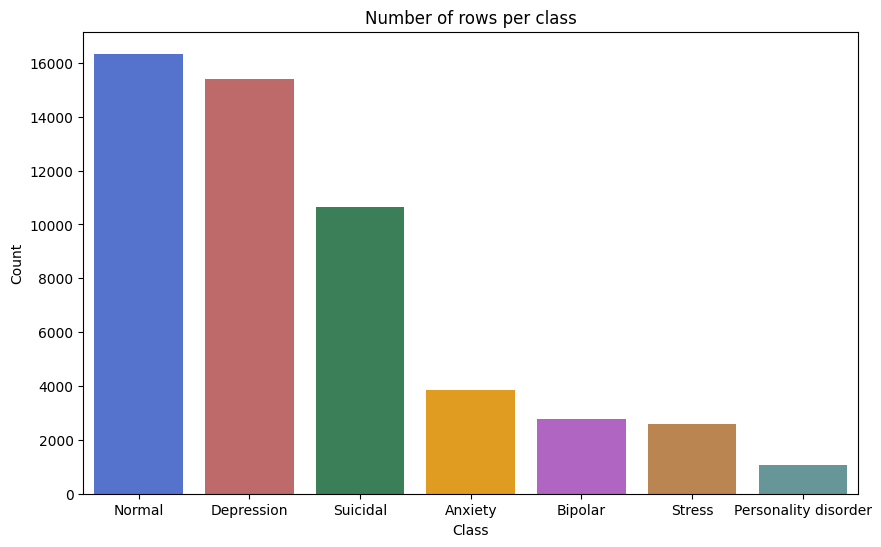

In [ ]:
# data per class
class_counts = data['status'].value_counts()

#plot class count
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette=class_colors)
plt.title('Number of rows per class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

We have an unbalanced dataset! We will need to treat this before making the model!

### 2.2 Statement distribution

#### Duplicated statements

In [ ]:
# is there any statement that appears more than once?
statement_counts = data['statement'].value_counts()
duplicated_statements = statement_counts[statement_counts.values > 1]
print("Number of duplicated statements:", len(duplicated_statements))

Number of duplicated statements: 1403


In [ ]:
#get duplicate statements class
duplicated_statements_data = data[data['statement'].isin(duplicated_statements.index)]
duplicated_statements_class = duplicated_statements_data['status'].value_counts()
display(duplicated_statements_class)

,count
status,
Depression,601
Stress,574
Bipolar,552
Normal,463
Anxiety,433
Personality disorder,362
Suicidal,26


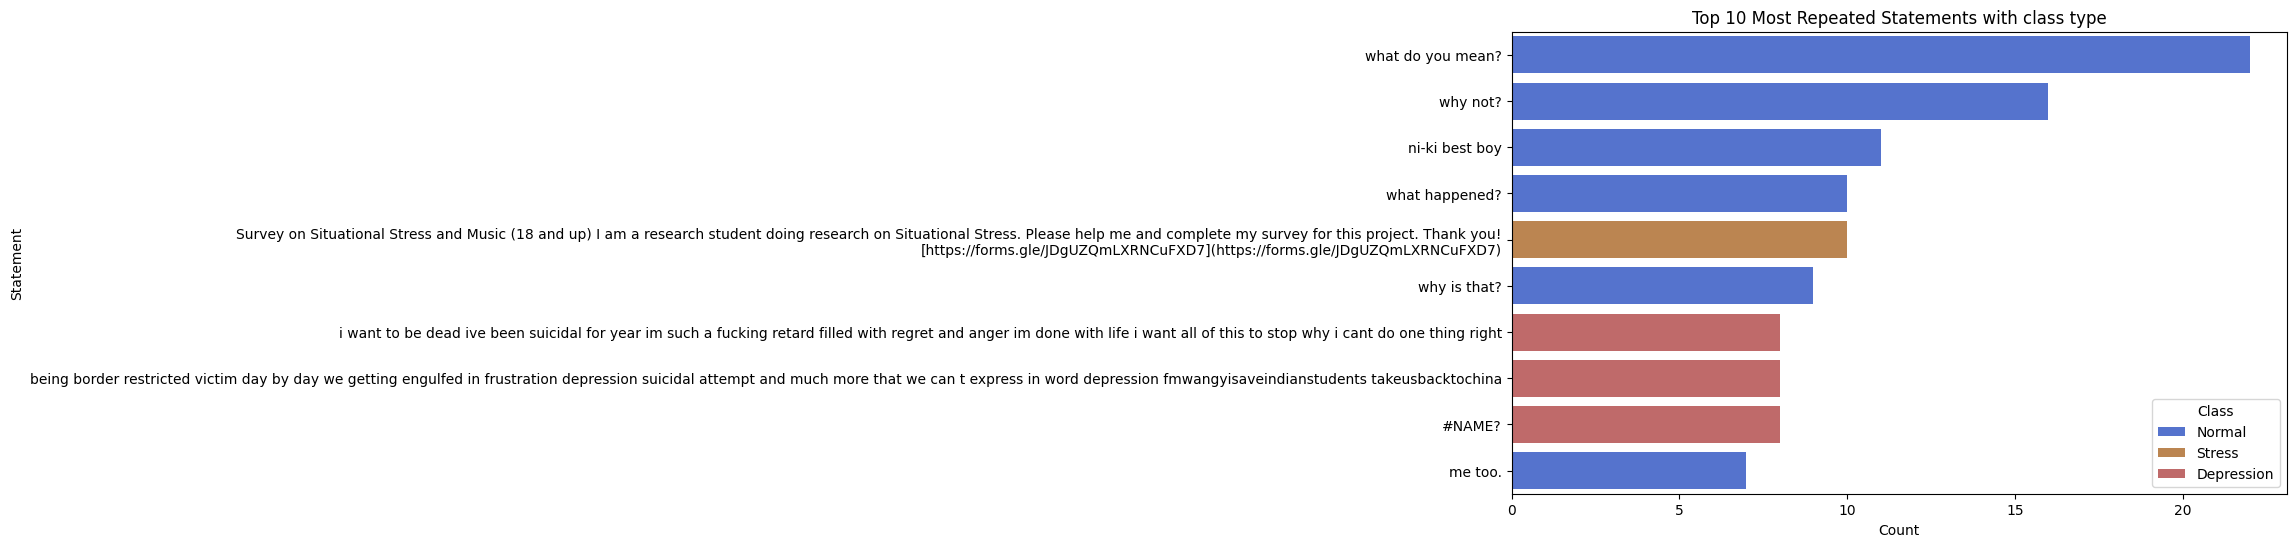

In [ ]:
#display top 10 duplicated statements with their class
grouped_duplicates = duplicated_statements_data.groupby(['statement', 'status']).size().reset_index(name='count')
grouped_duplicates = grouped_duplicates.sort_values(by='count', ascending=False)
grouped_duplicates.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_duplicates.head(10), x='count', y='statement', hue='status', palette=class_colors)
plt.title('Top 10 Most Repeated Statements with class type')
plt.xlabel('Count')
plt.ylabel('Statement')
plt.legend(title='Class')
plt.show()

#### Length of statement per class

Comparison of the length of the statements in each class

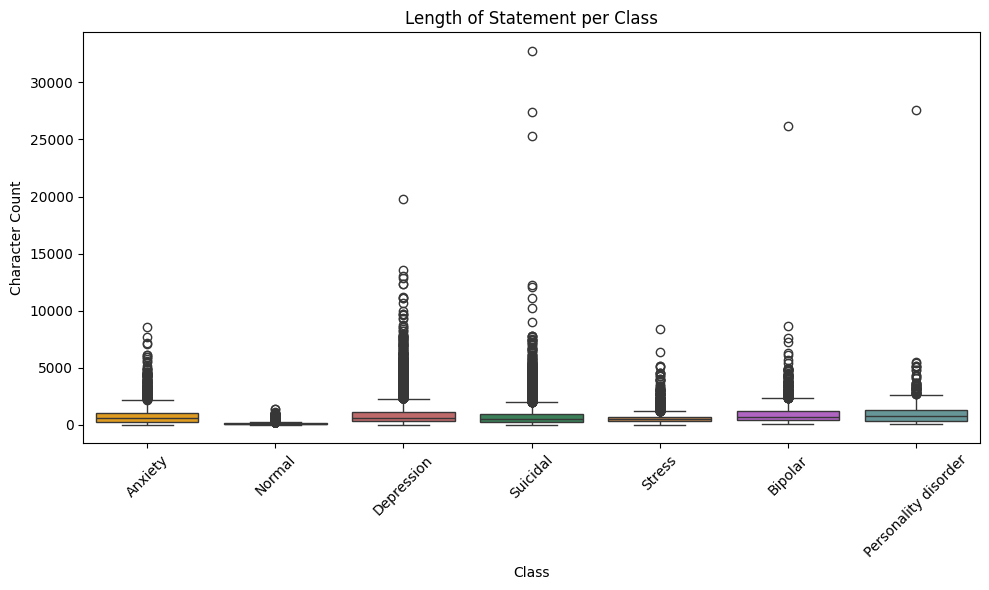

In [ ]:
#length of each statement
data_copy = data.copy()
data_copy['statement_length'] = data_copy['statement'].apply(len)

#plot boxplots to see class-comparison
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_copy, x='status', y='statement_length', hue="status", palette=class_colors)
plt.title('Length of Statement per Class')
plt.xlabel('Class')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
data_copy[data_copy['statement_length']>30000]


,statement,status,statement_length
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759


Distribution of the length of the statement at each class

<Figure size 640x480 with 0 Axes>

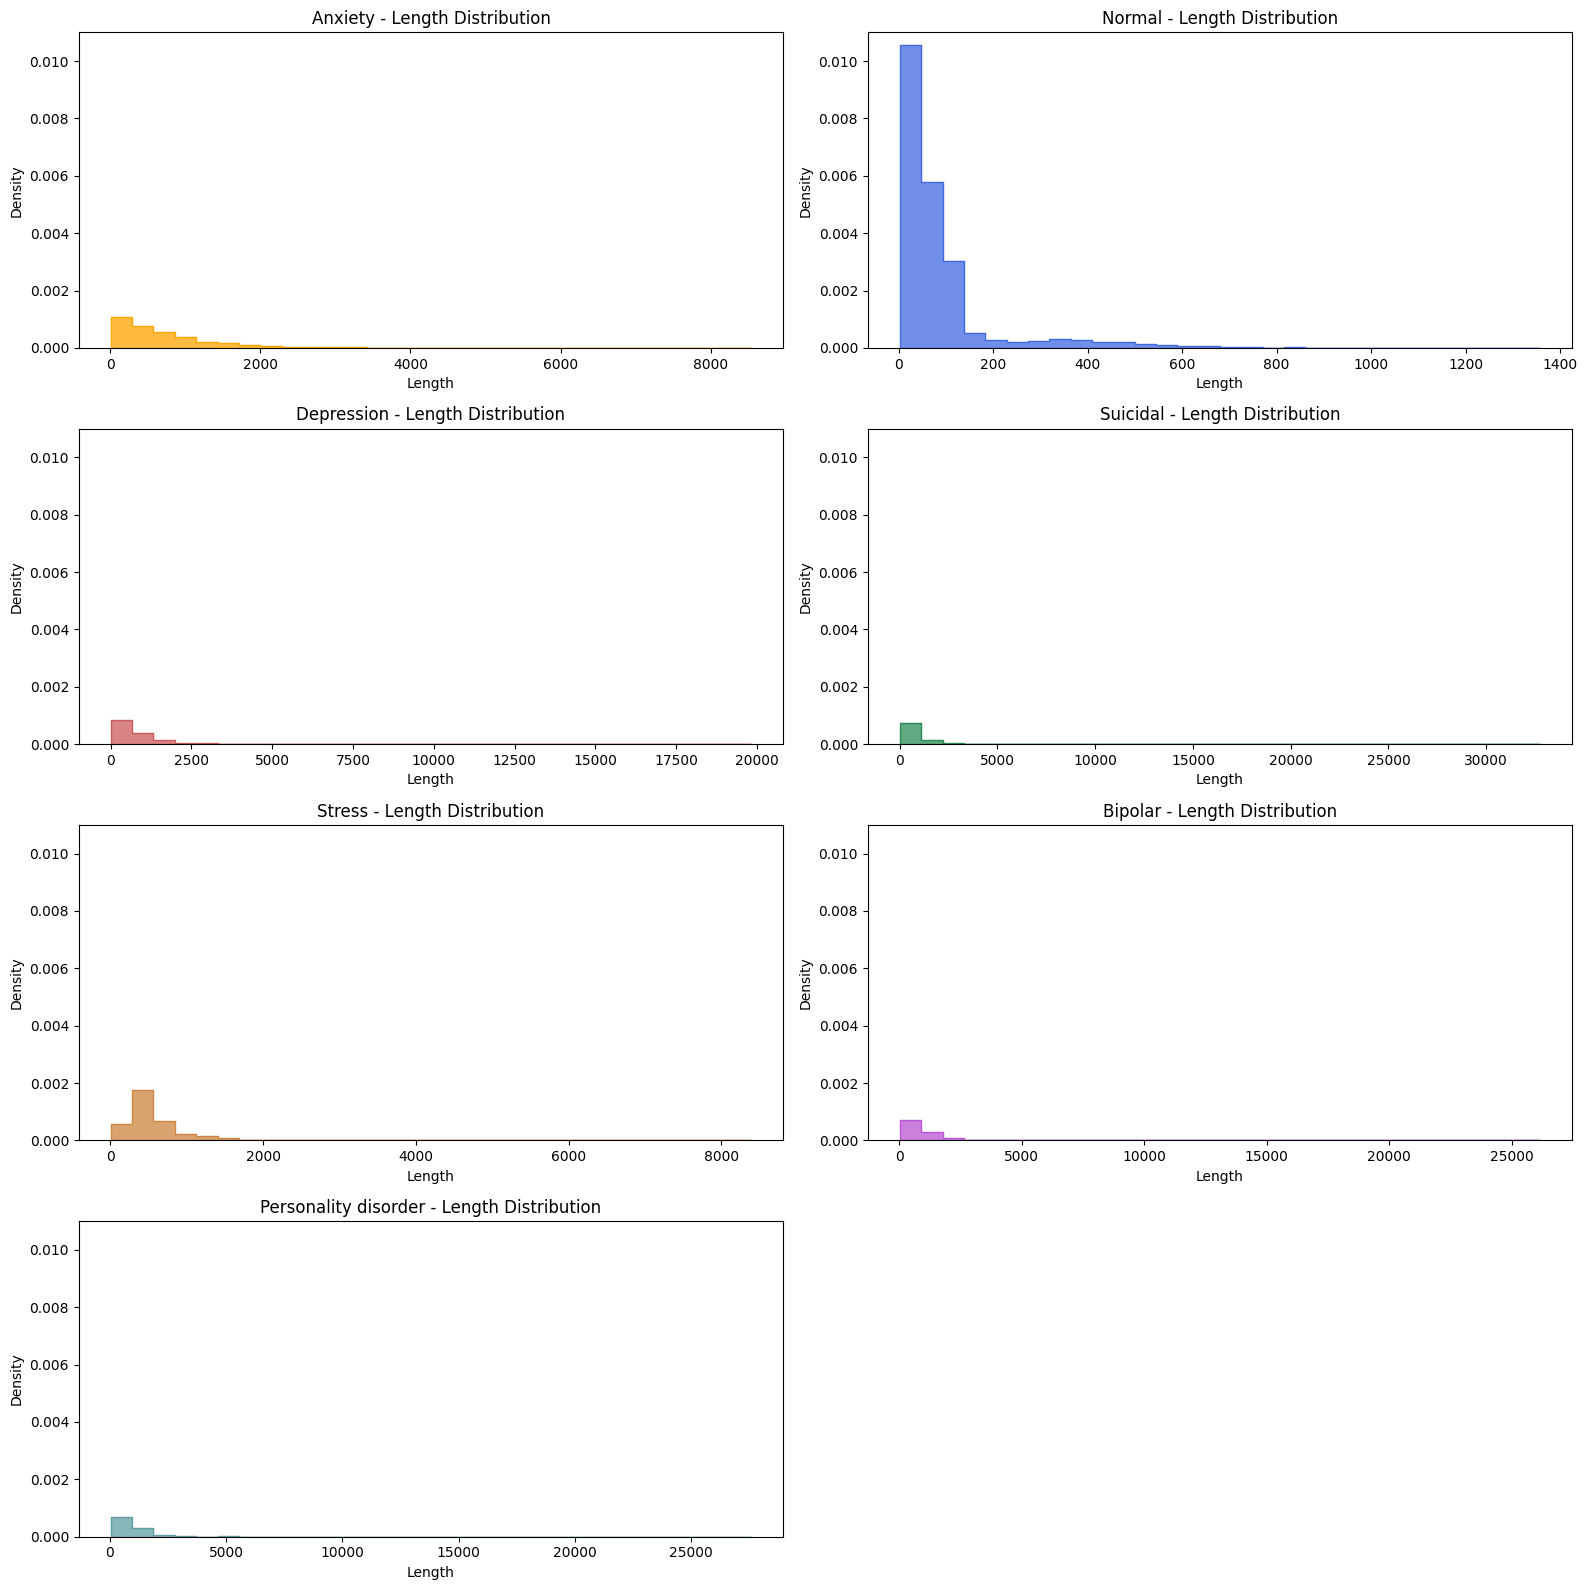

In [ ]:
#subplots
classes = data['status'].unique()
plt.figure()
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))  # 4x2 grid
axes = axes.flatten()

# Plot each class separately with fixed y-axis
for i, label in enumerate(classes):
    class_data = data_copy[data_copy['status'] == label]
    sns.histplot(data=class_data, x='statement_length', bins=30, stat='density',element='step', color=class_colors.get(label), ax=axes[i])
    axes[i].set_title(f"{label} - Length Distribution")
    #axes[i].set_xlim([0, data['statement_length'].max()])
    axes[i].set_ylim([0, 0.011])
    axes[i].set_xlabel("Length")
    axes[i].set_ylabel("Density")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


#### Text noise

In [ ]:
# Clean text and detect noise
def detect_noise(text):
    noise = {
        "hashtag": len(re.findall(r"#\w+", text)),
        "mention": len(re.findall(r"@\w+", text)),
        "url": len(re.findall(r"http\S+|www\S+", text)),
        "emoji": len(re.findall(r"[^\w\s,]", text)),
    }
    return pd.Series(noise)

noise_df = data["statement"].apply(detect_noise)

In [ ]:
display(noise_df.sum(axis=0))

,0
hashtag,1754
mention,1094
url,902
emoji,539952


When cleaning the text we will need to remove all this!

#### Most common words per class

In [ ]:
data_copy['cleaned_statement']=data_copy["statement"].apply(lambda x: clean_text(x))
display(data.head())

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
data_copy['statement_without_stopwords']=data_copy["cleaned_statement"].apply(lambda x: tokenize_and_remove_stopwords(x))
display(data_copy.head())

,statement,status,statement_length,cleaned_statement,statement_without_stopwords
0,oh my gosh,Anxiety,10,oh my gosh,"[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,trouble sleeping confused mind restless heart....,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,all wrong back off dear forward doubt. stay in...,"[wrong, back, dear, forward, doubt., stay, res..."
3,I've shifted my focus to something else but I'...,Anxiety,61,ive shifted my focus to something else but im ...,"[shifted, focus, something, else, still, worried]"
4,"I'm restless and restless, it's been a month n...",Anxiety,72,im restless and restless its been a month now ...,"[restless, restless, month, boy., mean]"


<Figure size 640x480 with 0 Axes>

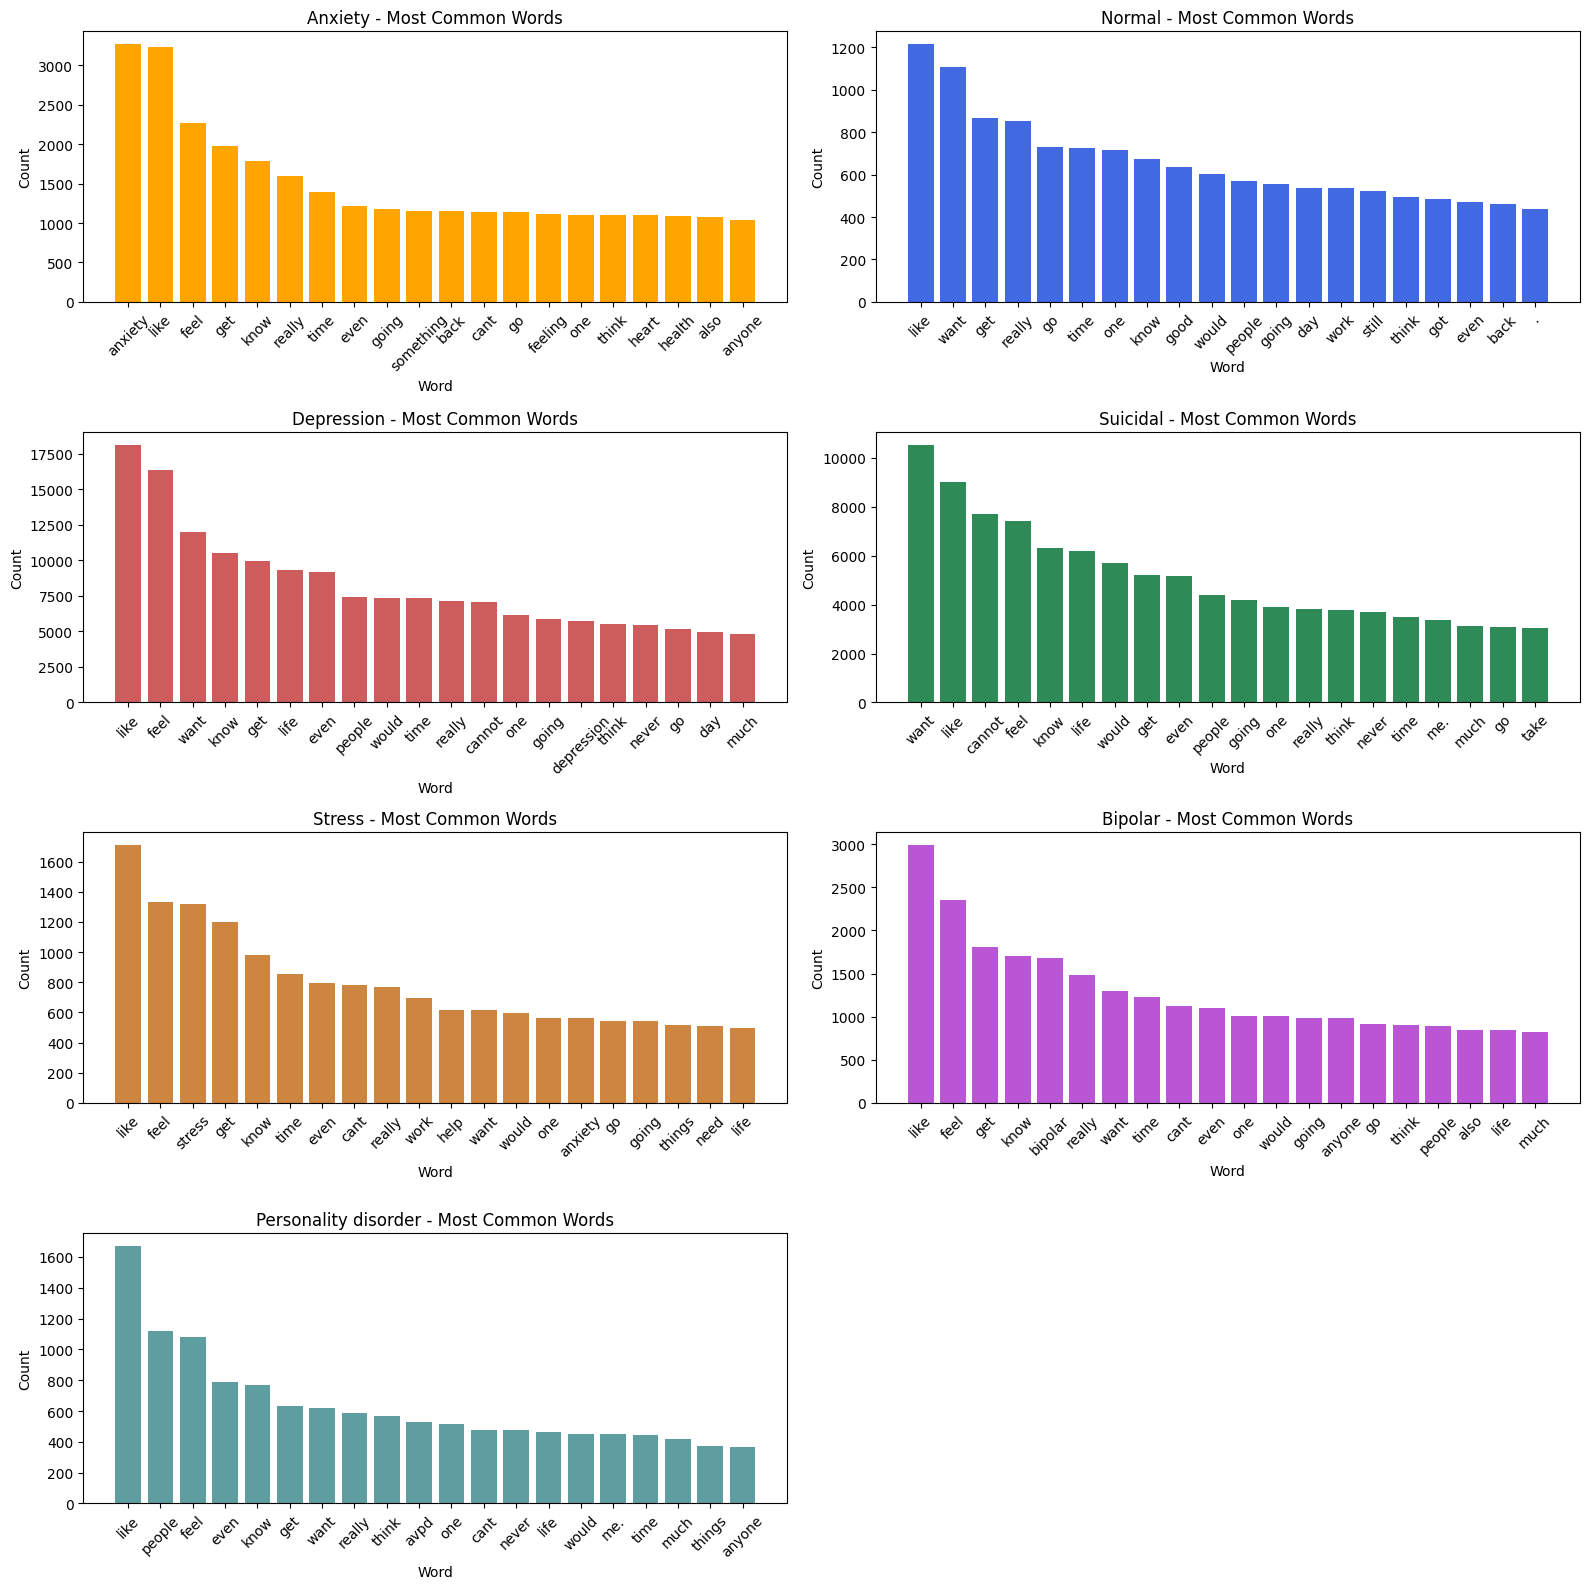

In [ ]:
#top words per class
classes = data_copy['status'].unique()
plt.figure()
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
axes = axes.flatten()

# Plot each class separately with fixed y-axis
for i, label in enumerate(classes):
    class_data = data_copy[data_copy['status'] == label]
    all_words = [word for sublist in class_data['statement_without_stopwords'] for word in sublist]
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(20)  #Top 20
    words, counts = zip(*most_common_words)
    axes[i].bar(words, counts, color=class_colors.get(label))
    axes[i].set_title(f"{label} - Most Common Words")
    axes[i].set_xlabel("Word")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Interesting: Lots of statements include the word! Anxiety, depression, bipolar, stress, and personality disorder include their words as most common words

#### Word cloud for each class

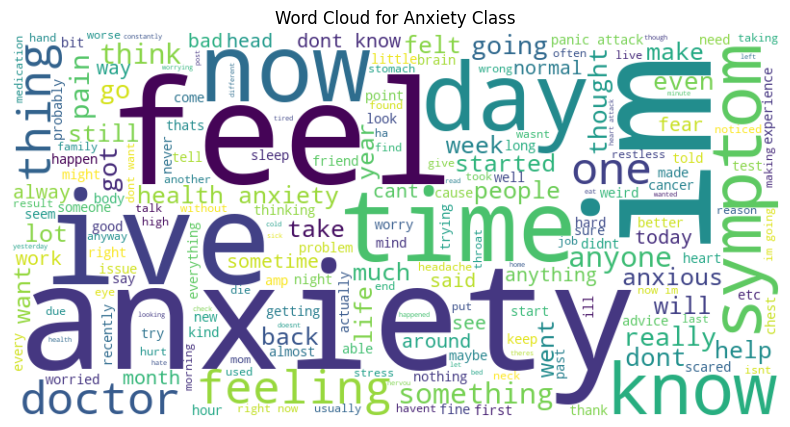

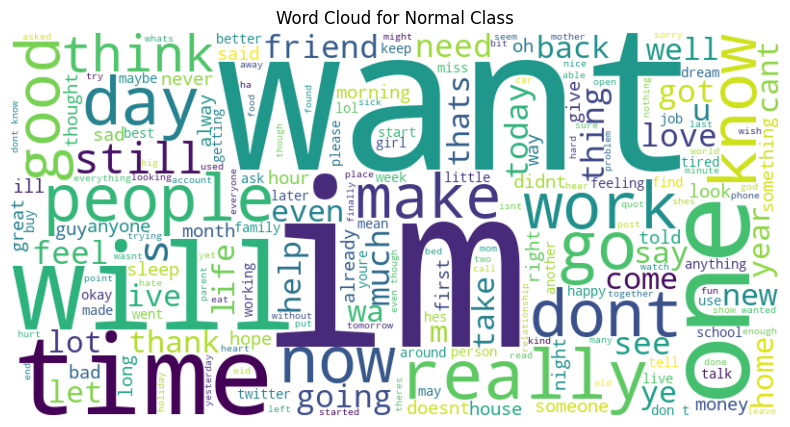

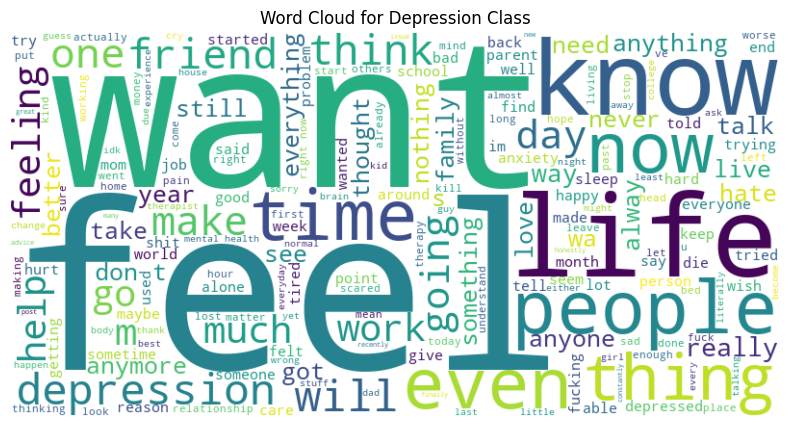

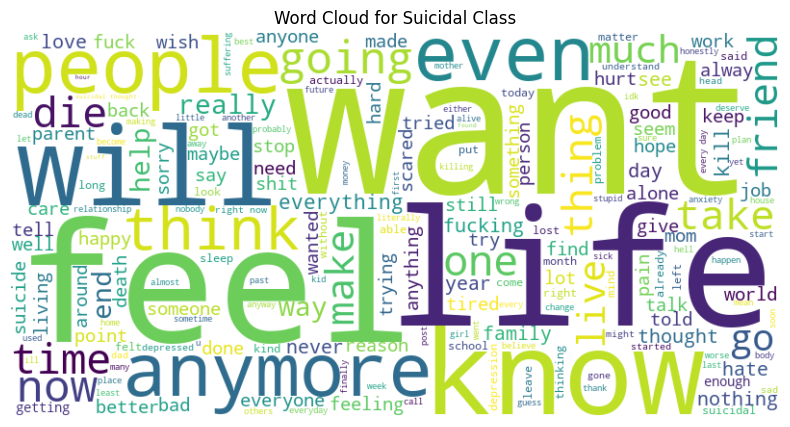

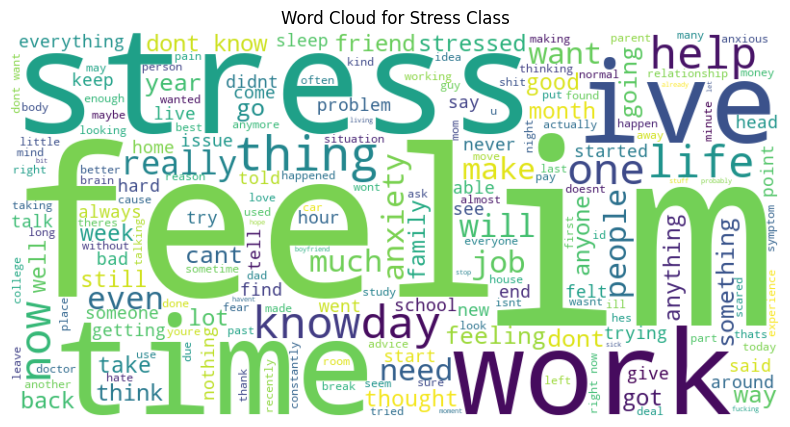

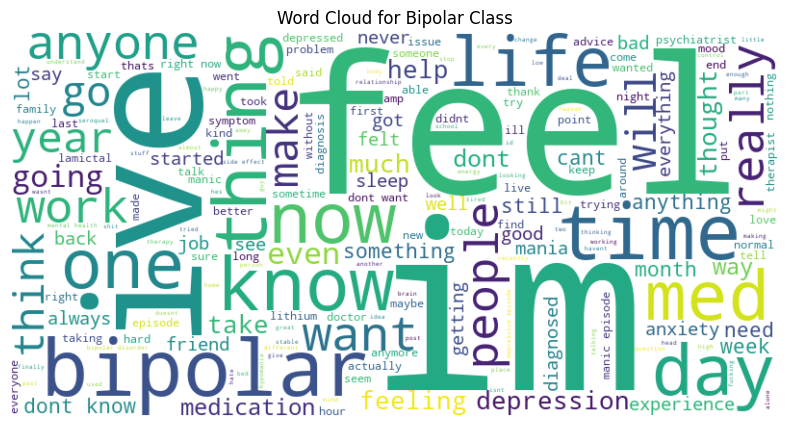

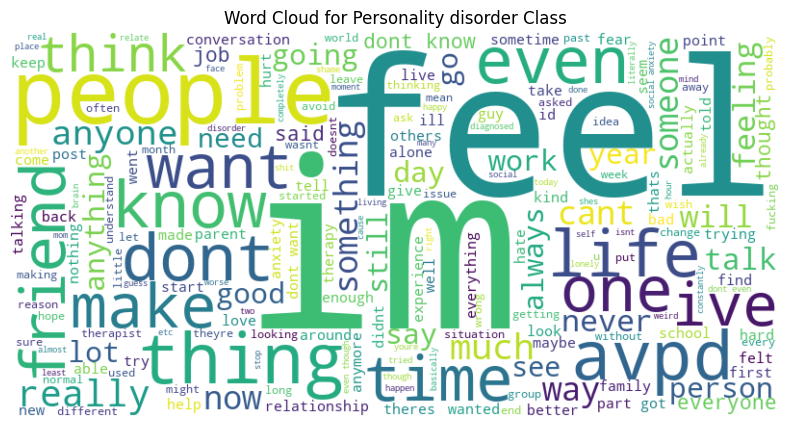

In [ ]:
# Word clouds for each class
from wordcloud import WordCloud

def generate_wordcloud(text, title=None):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

statuses = data_copy['status'].unique()
for status in statuses:
    text = ' '.join(data_copy[data_copy['status'] == status]['cleaned_statement'])
    generate_wordcloud(text, title=f'Word Cloud for {status} Class')

#### n-gram detection

In [ ]:
#bigrams
vectorizer_bi = CountVectorizer(ngram_range=(2, 2), stop_words="english", max_features=100)
data_bigrams = vectorizer_bi.fit_transform(data_copy["cleaned_statement"])
bigram_features = vectorizer_bi.get_feature_names_out()
bigram_df = pd.DataFrame(data_bigrams.toarray(), columns=bigram_features)

#overall frequencies
bigram_freq = bigram_df.sum().sort_values(ascending=False).head(10)
display(bigram_freq)

,0
feel like,11605
just want,4789
dont know,2554
feels like,2215
want die,2186
just feel,1897
mental health,1804
anymore anymore,1575
dont want,1372
felt like,1275


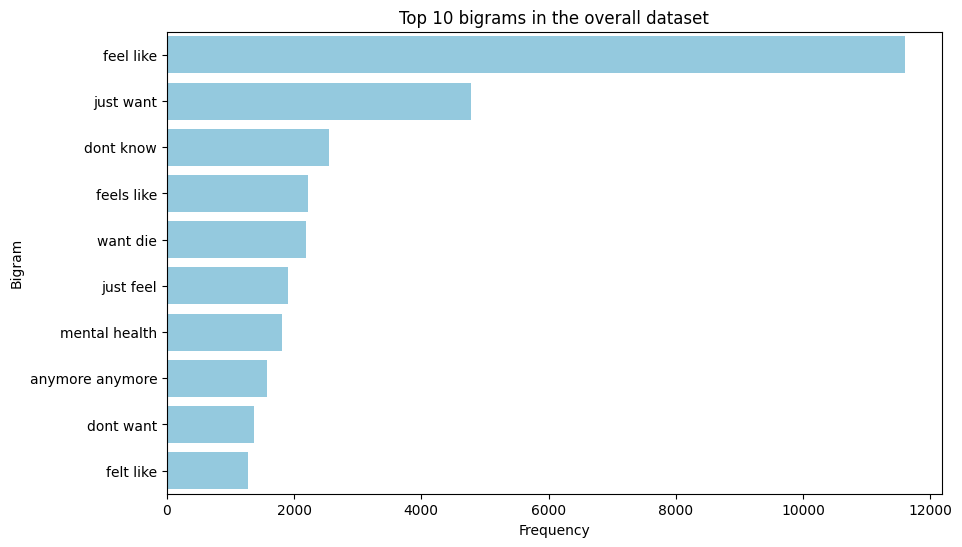

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(y=bigram_freq.index, x=bigram_freq.values,color="skyblue")
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Top 10 bigrams in the overall dataset')
plt.show()

In [ ]:
#class frequencies
bigram_df["status"] = data_copy["status"]
class_bigrams = bigram_df.groupby("status").sum()
display(class_bigrams)

,anxiety depression,anymore anymore,anymore just,best friend,day day,day just,days ago,depression anxiety,did want,die want,...,want just,want kill,want know,want live,want talk,weeks ago,year ago,year old,years ago,years old
status,,,,,,,,,,,,,,,,,,,,,
Anxiety,48,0,6,10,24,15,96,24,3,1,...,12,6,33,16,9,124,41,129,144,68
Bipolar,24,0,8,43,26,12,57,36,5,4,...,20,13,44,32,17,51,41,61,122,58
Depression,239,307,271,343,239,189,121,350,203,255,...,228,350,234,467,220,122,224,413,394,320
Normal,9,0,2,22,12,13,11,10,10,2,...,3,11,21,6,12,17,9,40,41,28
Personality disorder,12,0,3,14,8,5,16,7,4,1,...,10,3,16,6,13,11,7,21,42,31
Stress,20,0,7,30,25,7,23,28,4,0,...,11,0,19,4,9,20,9,44,57,46
Suicidal,96,1268,240,266,144,149,95,184,208,242,...,176,303,152,353,149,101,90,217,395,300


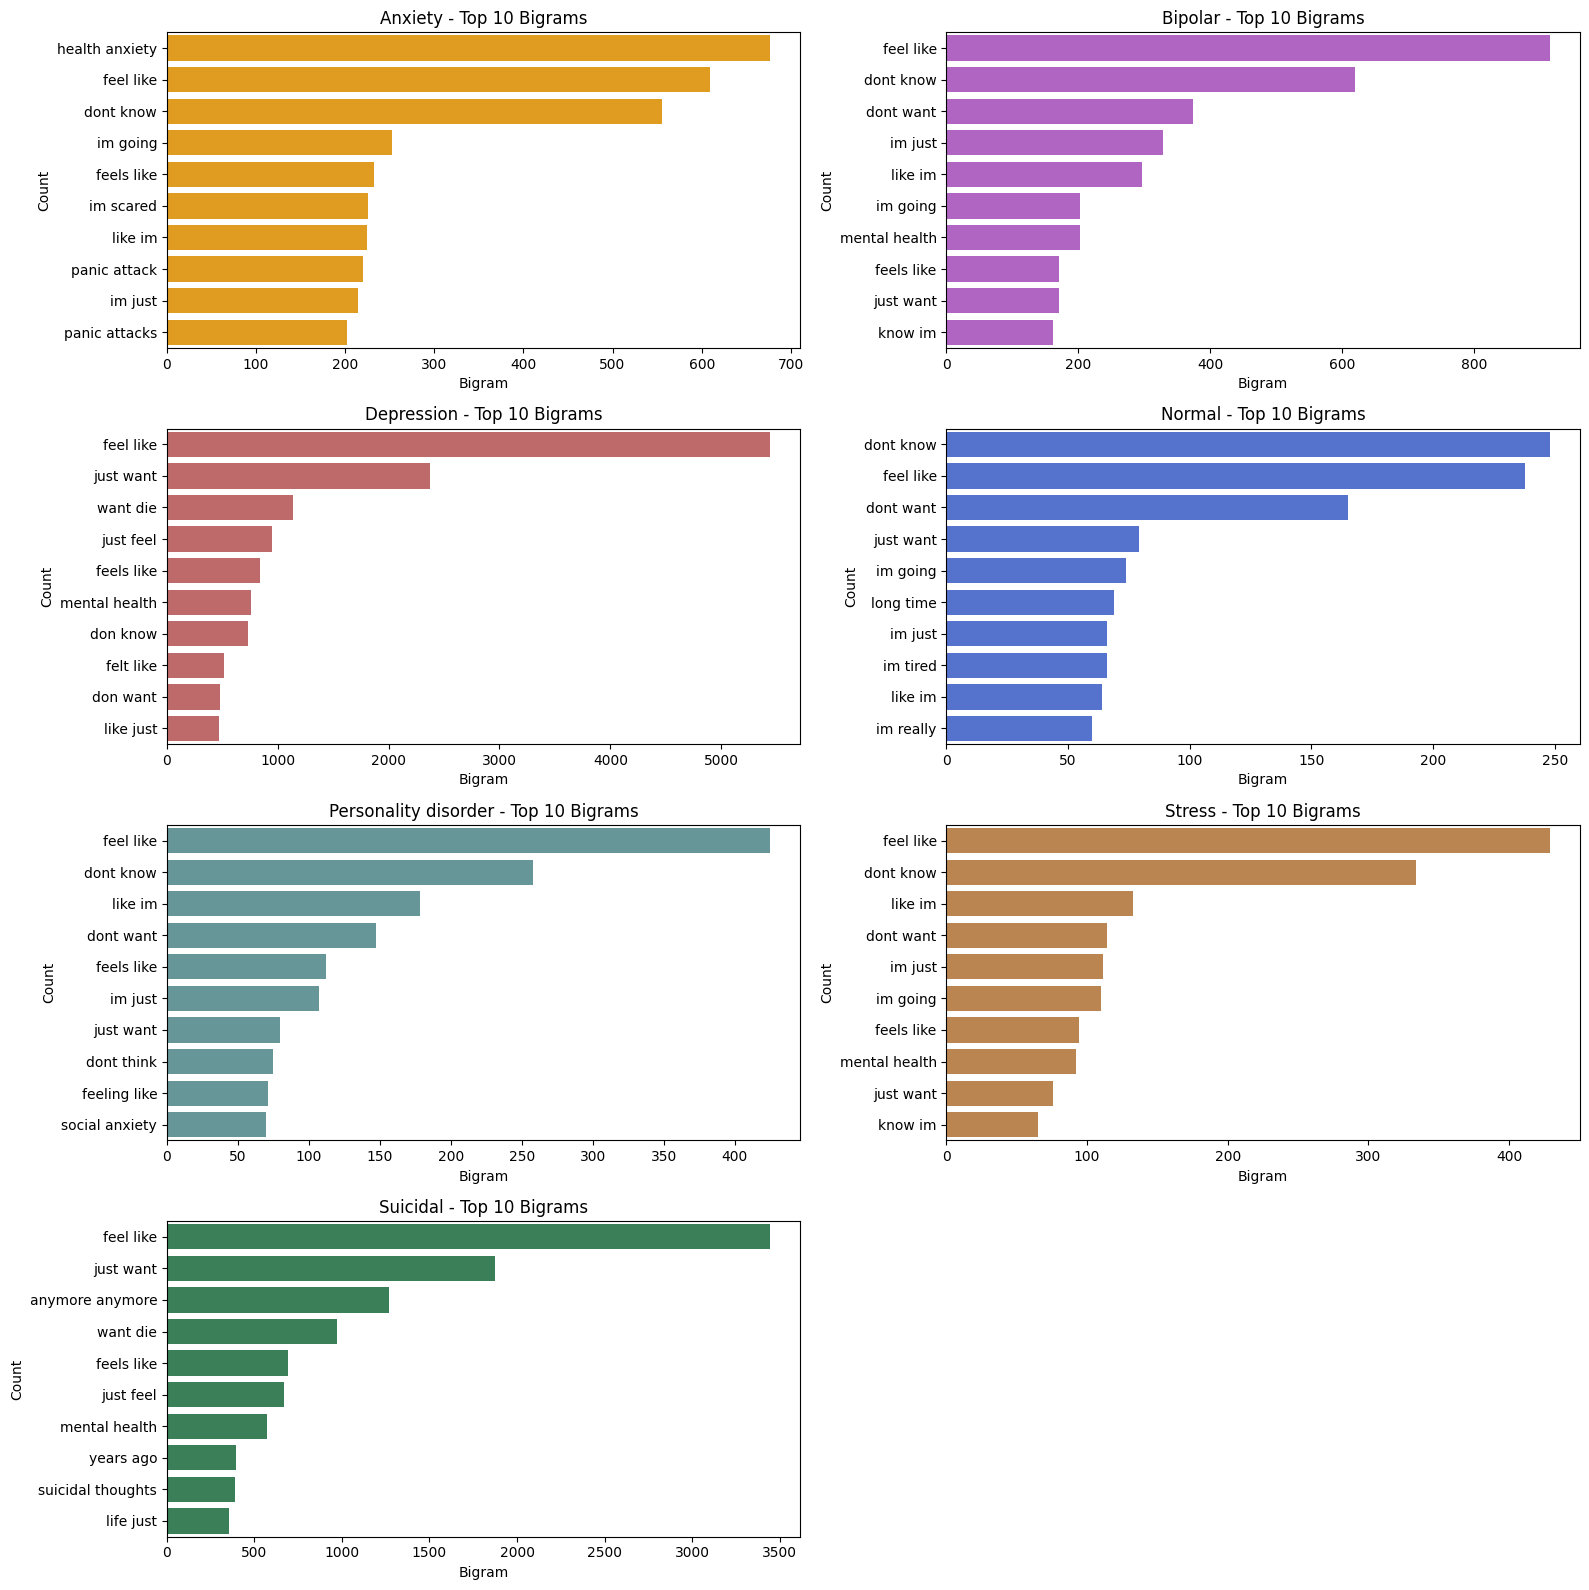

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
axes = axes.flatten()
i=0
for class_name, row in class_bigrams.iterrows():
    top_bigrams = row.sort_values(ascending=False).head(10)
    sns.barplot(y=top_bigrams.index, x=top_bigrams.values, color=class_colors.get(class_name), ax=axes[i])
    axes[i].set_title(f"{class_name} - Top 10 Bigrams")
    axes[i].set_xlabel("Bigram")
    axes[i].set_ylabel("Count")
    i=i+1

# Hide any unused subplots
for j in range(i, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()